# 🧭 From Raw Q&A to Specialty Taxonomy (Unsupervised → Minimal Hybrid)

## 🎯 Goals

Create a first-pass specialty label (y) for each record using an **ML-first approach**:

1. **Build text representations** (embeddings)
2. **Explore structure** (UMAP visualization)
3. **Learn k-means clustering** and choose k with evidence
4. **Manually name clusters** → preliminary taxonomy
5. **Add 5–10 surgical rules** for obvious fixes (hybrid)
6. **Export a clean dataset** with specialty for downstream supervised learning

### Why this design?

You're learning **clustering**. Rules are allowed only to patch systematic misses, not to replace ML discovery.

### 📦 Deliverables

- `data/processed/specialty_taxonomy_v1.csv` (includes specialty)
- `artifacts/cluster_label_map_v1.json` (cluster → human label)
- `artifacts/umap_2d.parquet` (2D coords for plots)

---


## 📝 Decisions Log

**Document your key decisions here as you work through the notebook:**

### Embedding Model Choice
- **Model:** _[TODO: Fill this in after completing Section 3]_
- **Why:** _[Explain your reasoning: medical vs. general, speed vs. quality]_

### BEST_K Choice
- **k =** _[TODO: Fill this in after completing Section 4]_
- **Evidence:** _[1-2 paragraphs: What did the elbow curve show? What was the silhouette score? Why did you choose this k?]_

### Surgical Rules (5-10 max)
_[TODO: Fill this in after completing Section 9]_

1. **Rule 1:** _[What pattern? → Which specialty? Why needed?]_
2. **Rule 2:** _[...]_
3. ...

---


## 0️⃣ Imports, Config, Paths


In [1]:
# [TODO] Imports
# Hint: pandas, numpy, pathlib, json, matplotlib, sklearn (KMeans, silhouette_score), 
#       umap-learn, sentence-transformers
import pandas as pd
import numpy as np
import pathlib
import json
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random
import umap
from sentence_transformers import SentenceTransformer
from pathlib import Path
import seaborn as sns


# [TODO] Set a reproducible seed (e.g., 42) for KMeans and UMAP
# Hint: np.random.seed, random.seed, pass random_state=SEED in models
random_state = 42



# [TODO] Define paths (Pathlib recommended)
# DATA_RAW = Path("../../../datasets/medquad.csv")
# DATA_OUT = Path("../data/processed")
# ARTIFACTS = Path("../artifacts")
# Ensure directories exist (mkdir parents=True, exist_ok=True)
DATA_RAW = Path("../../../datasets/medquad.csv")
DATA_OUT = Path("../../../data/processed")
ARTIFACTS = Path("../artifacts")

# Only create directories if they do not already exist
if not DATA_OUT.exists():
    DATA_OUT.mkdir(parents=True, exist_ok=True)

if not ARTIFACTS.exists():
    ARTIFACTS.mkdir(parents=True, exist_ok=True)



## 1️⃣ Load Data

We'll build one text unit per record. Best default for specialty inference is **question + answer concatenated** (more context). If you only have one field, just use it.

### Assumptions (edit as needed):
- Columns available: `focus_area`, `question`, `answer`
- Final text column: `text` (we'll create this by combining question + answer)

In [2]:
# [TODO] Load CSV
# df = pd.read_csv(DATA_RAW)
df = pd.read_csv(DATA_RAW)

# [TODO] Sanity check columns and row count
# print(df.columns); df.head()
# print(df.head())

# [TODO] Build the `text` column.
# Hint: Prefer question + " " + answer; fall back if a column is missing.
# df["text"] = ...
df["text"] = df["answer"]

# [TODO] Drop completely empty/NaN texts and trim whitespace
df = df[~df["text"].isna()].copy()
df["text"] = df["text"].str.strip()

# [TODO] Optional: keep only essential columns or add an ID if missing
# If no ID exists: df['id'] = range(len(df))
df['id'] = range(len(df))
df = df[['id', 'text']]
print(df.head())


   id                                               text
0   0  Glaucoma is a group of diseases that can damag...
1   1  Nearly 2.7 million people have glaucoma, a lea...
2   2  Symptoms of Glaucoma  Glaucoma can develop in ...
3   3  Although open-angle glaucoma cannot be cured, ...
4   4  Glaucoma is a group of diseases that can damag...


## 2️⃣ Light Preprocessing

Transformers don't need heavy cleaning. Keep it minimal:

- ✅ Normalize whitespace
- ❓ Lowercasing (optional - embeddings handle case)
- ❌ No stemming/lemmatization
- ❌ Keep domain terms (don't strip "diabetes", "TNM", etc.)

In [3]:
# [TODO] Minimal normalization step(s)
# Hint: df["text_proc"] = df["text"].str.replace(r"\s+", " ", regex=True)
# Optional: .str.lower() if you want
# Decide and document it in a variable, e.g., USE_LOWER = False
df["text_proc"] = df["text"].str.replace(r"\s+", " ", regex=True)
df["text_proc"] = df["text_proc"].str.strip().str.lower()




# Print a few samples to verify
print(df.head())

   id                                               text  \
0   0  Glaucoma is a group of diseases that can damag...   
1   1  Nearly 2.7 million people have glaucoma, a lea...   
2   2  Symptoms of Glaucoma  Glaucoma can develop in ...   
3   3  Although open-angle glaucoma cannot be cured, ...   
4   4  Glaucoma is a group of diseases that can damag...   

                                           text_proc  
0  glaucoma is a group of diseases that can damag...  
1  nearly 2.7 million people have glaucoma, a lea...  
2  symptoms of glaucoma glaucoma can develop in o...  
3  although open-angle glaucoma cannot be cured, ...  
4  glaucoma is a group of diseases that can damag...  


## 3️⃣ Embeddings

Use a **sentence embedding model**. Options:

### Medical-leaning models:
- `pritamdeka/BioBERT-mnli-snli-scitail-mednli` (best for medical text)
- `dmis-lab/biobert-base-cased-v1.1` (needs sentence-transformers wrapper)

### General baseline models:
- `sentence-transformers/all-MiniLM-L6-v2` (fast, decent, 384-dim)
- `sentence-transformers/all-mpnet-base-v2` (slower, better, 768-dim)

### Trade-off:
- **Medical models** = better semantics for clinical terms
- **General model** = faster & lighter

**Pick one and state why in the Decisions Log above!**

In [4]:
# [TODO] Load a SentenceTransformer model by name
# Hint: from sentence_transformers import SentenceTransformer
# model = SentenceTransformer("<model-name>")
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")

# [TODO] Compute embeddings for df["text_proc"] (or df["text"])
X = model.encode(df["text_proc"].tolist(), batch_size=32, show_progress_bar=True, 
                 convert_to_numpy=True, normalize_embeddings=True)


# [TODO] Sanity check shape: (n_samples, embedding_dim)
print(f"Embeddings shape: {X.shape}")
# Expected: (16398, 384) or (16398, 768) depending on model

Batches:   0%|          | 0/513 [00:00<?, ?it/s]

Embeddings shape: (16407, 768)


## 4️⃣ Picking k: Evidence over Vibes

You'll learn k-means by comparing k values:

### Two Key Metrics:

1. **Inertia (distortion):** Sum of squared distances to cluster centers
   - Goes down with higher k (use elbow to find diminishing returns)
   - Look for the "elbow" where improvement flattens

2. **Silhouette score:** Measures cluster separation quality
   - Range: [-1, 1], higher is better
   - > 0.5 = good separation
   - 0.3-0.5 = reasonable
   - < 0.3 = poor/overlapping clusters

### Strategy:
Try k in `[8, 10, 12, 14, 16, 18, 20, 22, 24, 26]` (adjust for dataset size). 

Choose a **justified k** (not perfect, just argued with evidence).

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


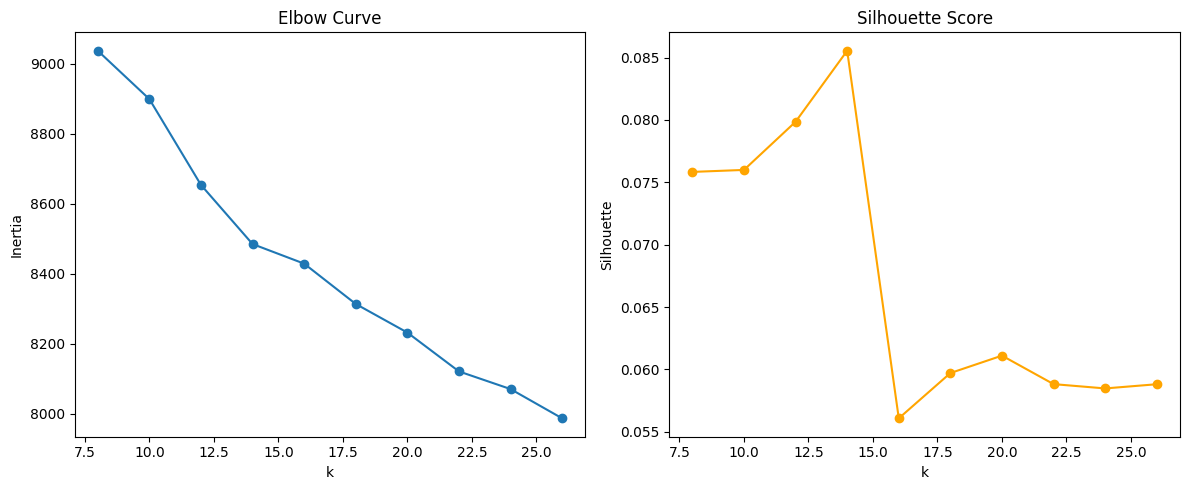

✅ Chosen k = 13


<Figure size 640x480 with 0 Axes>

In [5]:
# [TODO] Define K_RANGE = list(range(8, 27, 2))  # example: step by 2
K_RANGE = list(range(8, 27, 2))

# [TODO] For each k:
#   - fit KMeans(n_clusters=k, n_init="auto" or 10+, random_state=SEED)
#   - record inertia_
#   - compute silhouette_score(X, labels)  # may be slow on huge data; sample if needed
# Hint: Store results in two lists: inertias = [], silhouettes = []
inertias = []
silhouettes = []

for k in K_RANGE:
    km = KMeans(n_clusters=k, n_init="auto", random_state=random_state)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X, labels))


# [TODO] Plot k vs inertia (elbow curve)
# Hint: plt.figure(figsize=(12,5))
#       plt.subplot(1,2,1) for inertia
#       plt.plot(K_RANGE, inertias, marker='o')
#       plt.xlabel('k'), plt.ylabel('Inertia'), plt.title('Elbow Curve')
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K_RANGE, inertias, marker='o')
plt.xlabel('k'), plt.ylabel('Inertia'), plt.title('Elbow Curve')


# [TODO] Plot k vs silhouette score
#       plt.subplot(1,2,2) for silhouette
#       plt.plot(K_RANGE, silhouettes, marker='o', color='orange')
#       plt.xlabel('k'), plt.ylabel('Silhouette'), plt.title('Silhouette Score')
#       plt.tight_layout(), plt.show()
plt.subplot(1,2,2)
plt.plot(K_RANGE, silhouettes, marker='o', color='orange')
plt.xlabel('k'), plt.ylabel('Silhouette'), plt.title('Silhouette Score')
plt.tight_layout()
plt.show()

# Save to images with the correct name
import os
os.makedirs("../images", exist_ok=True)
plt.savefig("../images/elbow_silhouette.png")

# [TODO] Based on these plots, set BEST_K = ...
BEST_K = 13
print(f"✅ Chosen k = {BEST_K}")
# Now go back to the Decisions Log and document WHY you chose this k!

## 5️⃣ Train Final KMeans

Now fit the final model with your chosen `BEST_K`. This is the **unsupervised "discovery" step** that gives you cluster IDs.

### What KMeans Does:
1. Randomly initialize k cluster centers
2. Assign each point to nearest center
3. Move centers to mean of assigned points
4. Repeat steps 2-3 until convergence
5. Output: cluster_id for each sample

In [6]:
# [TODO] Fit final KMeans with BEST_K
BEST_K = 13

km = KMeans(n_clusters=BEST_K, n_init=10, random_state=random_state, verbose=1)
cluster_ids = km.fit_predict(X)


# [TODO] Attach cluster_ids to df
df["cluster_id"] = cluster_ids


# [TODO] Check cluster size distribution
df["cluster_id"].value_counts().sort_index()

Initialization complete
Iteration 0, inertia 14574.7626953125.
Iteration 1, inertia 9052.181640625.
Iteration 2, inertia 8870.658203125.
Iteration 3, inertia 8813.5654296875.
Iteration 4, inertia 8778.6328125.
Iteration 5, inertia 8763.416015625.
Iteration 6, inertia 8752.728515625.
Iteration 7, inertia 8745.162109375.
Iteration 8, inertia 8739.890625.
Iteration 9, inertia 8736.6005859375.
Iteration 10, inertia 8733.74609375.
Iteration 11, inertia 8731.1376953125.
Iteration 12, inertia 8726.4296875.
Iteration 13, inertia 8708.662109375.
Iteration 14, inertia 8656.8271484375.
Iteration 15, inertia 8624.01953125.
Iteration 16, inertia 8617.576171875.
Iteration 17, inertia 8615.6708984375.
Iteration 18, inertia 8614.408203125.
Iteration 19, inertia 8613.7529296875.
Iteration 20, inertia 8613.125.
Iteration 21, inertia 8612.3603515625.
Iteration 22, inertia 8611.8310546875.
Iteration 23, inertia 8611.3984375.
Iteration 24, inertia 8611.0341796875.
Iteration 25, inertia 8610.6015625.
Iterat

cluster_id
0     1049
1     1929
2      970
3     1331
4     1080
5     2100
6      284
7     1249
8     1159
9     1324
10    1582
11    1441
12     909
Name: count, dtype: int64

## 6️⃣ Visualize Structure with UMAP

**Visualization is for your brain, not the algorithm.** 

Use UMAP (2D) to inspect the structure and color by cluster. This won't change labels; it helps you **understand what k-means found**.

### UMAP Parameters:
- `n_neighbors`: Local vs. global structure (15 is a good default)
- `min_dist`: How tightly to pack points (0.1 is standard)
- `metric`: Use "cosine" for text embeddings

✅ UMAP imported successfully!
UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, random_state=42, verbose=True)
Sat Nov  1 18:44:57 2025 Construct fuzzy simplicial set


/Users/franciscoteixeirabarbosa/.pyenv/versions/3.11.7/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Sat Nov  1 18:44:57 2025 Finding Nearest Neighbors
Sat Nov  1 18:44:57 2025 Building RP forest with 11 trees
Sat Nov  1 18:45:01 2025 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	Stopping threshold met -- exiting after 6 iterations
Sat Nov  1 18:45:09 2025 Finished Nearest Neighbor Search
Sat Nov  1 18:45:11 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Nov  1 18:45:19 2025 Finished embedding


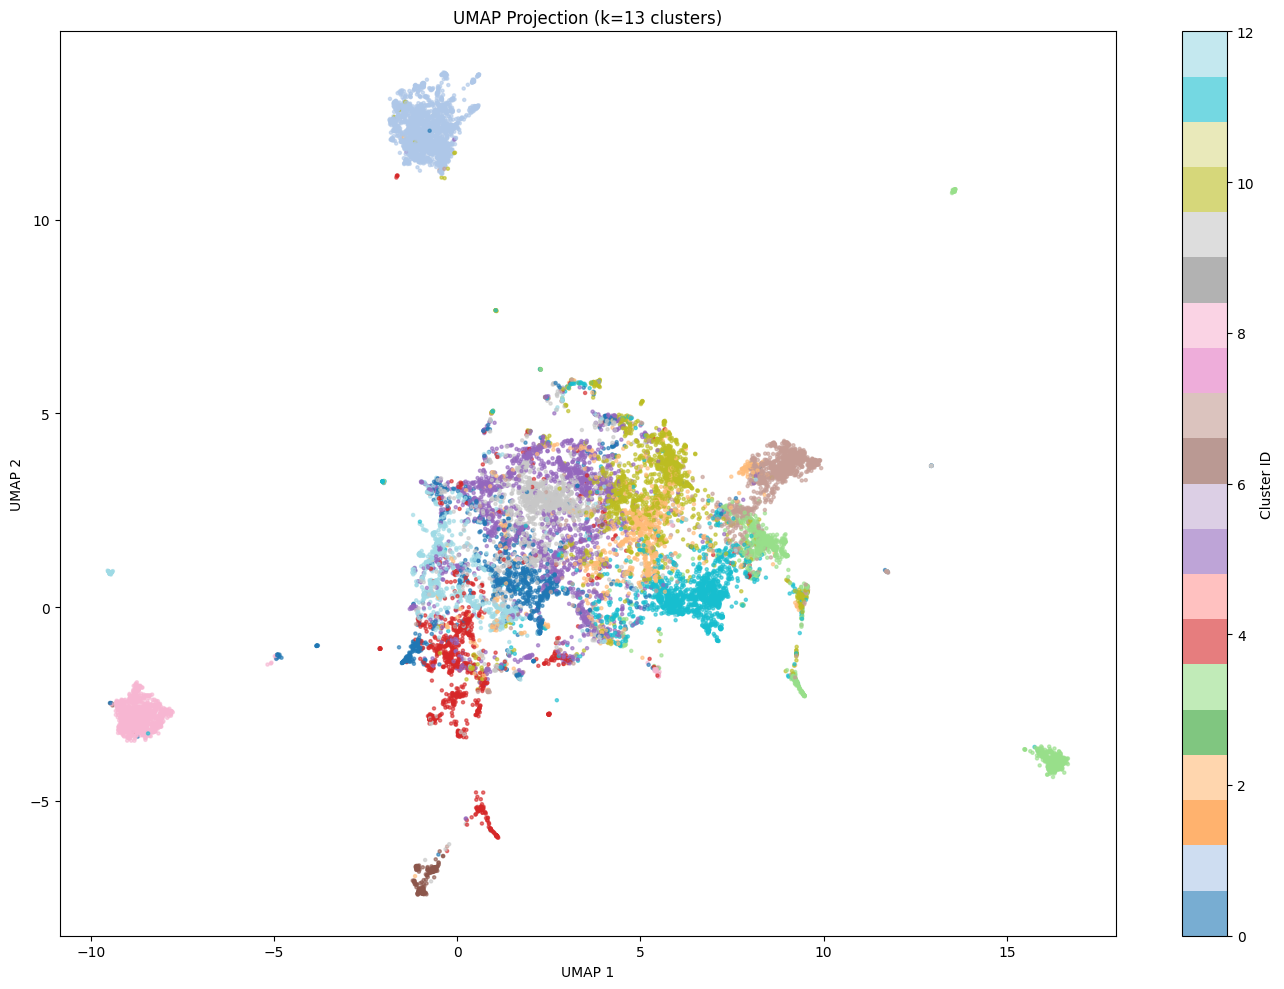

In [7]:
# [TODO] Fit UMAP on X → 2D
# Hint: import umap
from umap.umap_ import UMAP

print("✅ UMAP imported successfully!")
# umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, 
#                        metric="cosine", random_state=SEED, verbose=True)
# Z = umap_model.fit_transform(X)
umap_model = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, 
                       metric="cosine", random_state=random_state, verbose=True)
Z = umap_model.fit_transform(X)

# [TODO] Save Z to artifacts for reuse
# Convert Z to a DataFrame with id, cluster_id, x, y and save as parquet
# umap_df = pd.DataFrame({
#     'id': df['id'],
#     'cluster_id': df['cluster_id'],
#     'umap_x': Z[:, 0],
#     'umap_y': Z[:, 1]
# })
# umap_df.to_parquet(ARTIFACTS / "umap_2d.parquet", index=False)
umap_df = pd.DataFrame({
    'id': df['id'],
    'cluster_id': df['cluster_id'],
    'umap_x': Z[:, 0],
    'umap_y': Z[:, 1]
})
umap_df.to_parquet(ARTIFACTS / "umap_2d.parquet", index=False)



# [TODO] Simple scatter plot: x vs y, colored by cluster_id
# plt.figure(figsize=(14, 10))
# scatter = plt.scatter(Z[:, 0], Z[:, 1], c=df['cluster_id'], 
#                       cmap='tab20', s=5, alpha=0.6)
# plt.colorbar(scatter, label='Cluster ID')
# plt.xlabel('UMAP 1'), plt.ylabel('UMAP 2')
# plt.title(f'UMAP Projection (k={BEST_K} clusters)')
# plt.tight_layout()
# plt.show()
plt.figure(figsize=(14, 10))
scatter = plt.scatter(Z[:, 0], Z[:, 1], c=df['cluster_id'], 
                      cmap='tab20', s=5, alpha=0.6)
plt.colorbar(scatter, label='Cluster ID')
plt.xlabel('UMAP 1'), plt.ylabel('UMAP 2')
plt.title(f'UMAP Projection (k={BEST_K} clusters)')
plt.tight_layout()
plt.savefig("../images/umap_2d.png")
plt.show()

## 7️⃣ Understand Clusters: Representatives & Keywords

Before naming clusters, explore what's inside them:

### Two Techniques:

1. **Representatives:** Show 10 sample texts per cluster
   - Gives you a "feel" for what the cluster contains
   - Look for common themes

2. **Keywords per cluster:** Compute TF-IDF on texts within each cluster
   - Surfaces the most distinctive terms
   - This is descriptive analysis, not the clustering itself

You'll use these to **manually map cluster → specialty**.

In [8]:
# [TODO] For each cluster_id:
#   - print count
#   - show N (e.g., 10) representative texts (shortened to first 200 chars)
# Hint: 
# for cluster_id in sorted(df['cluster_id'].unique()):
#     cluster_df = df[df['cluster_id'] == cluster_id]
#     print(f"\n{'='*80}")
#     print(f"Cluster {cluster_id} | Size: {len(cluster_df)}")
#     print(f"{'='*80}")
#     samples = cluster_df.sample(n=min(10, len(cluster_df)), random_state=SEED)
#     for idx, row in samples.iterrows():
#         print(f"  • {row['text'][:200]}...")

for cluster_id in sorted(df['cluster_id'].unique()):
    cluster_df = df[df['cluster_id'] == cluster_id]
    print(f"\n{'='*80}")
    print(f"Cluster {cluster_id} | Size: {len(cluster_df)}")
    print(f"{'='*80}")
    samples = cluster_df.sample(n=min(10, len(cluster_df)), random_state=random_state)
    for idx, row in samples.iterrows():
        print(f"    ·{row['text'][:200]}...")
        


Cluster 0 | Size: 1049
    ·Summary : Your diet is made up of what you eat. A healthy diet        - May include fruits, vegetables, whole grains, and fat-free or low-fat milk and milk products    - May include lean meats, poultr...
    ·Chronic hepatitis C is a long-lasting infection with the hepatitis C virus. Chronic hepatitis C occurs when the body cant get rid of the hepatitis C virus. Most hepatitis C infections become chronic.
...
    ·If you have diabetes, you are at least twice as likely as someone who does not have diabetes to have heart disease or a stroke. People with diabetes also tend to develop heart disease or have strokes ...
    ·The liver is an organ that does many important things. You cannot live without a liver.
                
*See the Pronunciation Guide for tips on how to say the words in bold type.
                
Th...
    ·Diabetes is often called a "silent" disease because it can cause serious complications even before you have symptoms. Symptoms can also

In [9]:
# [TODO] Compute cluster-wise TF-IDF keywords
# For each cluster, fit a TF-IDF on its texts and extract top N terms
# Hint: 
# from sklearn.feature_extraction.text import TfidfVectorizer
# 
# for cluster_id in sorted(df['cluster_id'].unique()):
#     cluster_texts = df[df['cluster_id'] == cluster_id]['text_proc'].tolist()
#     
#     if len(cluster_texts) < 5:  # Skip tiny clusters
#         continue
#     
#     vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1,2), 
#                                   stop_words='english', min_df=2)
#     tfidf_matrix = vectorizer.fit_transform(cluster_texts)
#     feature_names = vectorizer.get_feature_names_out()
#     
#     # Get top terms
#     scores = tfidf_matrix.sum(axis=0).A1
#     top_indices = scores.argsort()[-15:][::-1]
#     top_terms = [feature_names[i] for i in top_indices]
#     
#     print(f"\nCluster {cluster_id} keywords: {', '.join(top_terms)}")

from sklearn.feature_extraction.text import TfidfVectorizer

for cluster_id in sorted(df['cluster_id'].unique()):
    cluster_texts = df[df['cluster_id'] == cluster_id]['text_proc'].tolist()
    
    if len(cluster_texts) < 5:  # Skip tiny clusters
        continue
    
    vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1,2), 
                                  stop_words='english', min_df=2)
    tfidf_matrix = vectorizer.fit_transform(cluster_texts)
    feature_names = vectorizer.get_feature_names_out()
    
    scores = tfidf_matrix.sum(axis=0).A1
    top_indices = scores.argsort()[-15:][::-1]
    top_terms = [feature_names[i] for i in top_indices]
    
    print(f"\nCluster {cluster_id} keywords: {', '.join(top_terms)}")



Cluster 0 keywords: risk, people, health, disease, blood, help, cancer, diabetes, care, heart, body, high, factors, type, cholesterol

Cluster 1 keywords: symptom, number, 90, information, patients, people, frequency, 50, sign, signs, symptoms, signs symptoms, 25, available, sign symptom

Cluster 2 keywords: syndrome, condition, children, symptoms, people, affected, blood, individuals, disease, disorder, brain, birth, problems, signs, usually

Cluster 3 keywords: gene, condition, autosomal, recessive, autosomal recessive, inherited, disorder, copy, cell, cases, pattern, affected, gene cell, means, mutations

Cluster 4 keywords: cancer, treatment, cells, tumor, blood, body, tests, clinical, trials, used, therapy, surgery, clinical trials, patients, spread

Cluster 5 keywords: symptoms, people, disease, blood, cause, condition, pain, skin, include, body, signs, common, usually, syndrome, treatment

Cluster 6 keywords: research, disorders, ninds, national, supports, treat, prevent, ways,

## 8️⃣ Manual Cluster Naming

Create a mapping from `cluster_id → specialty` (your taxonomy). 

### Guidelines:
- Keep names consistent (e.g., "Oncology", "Endocrinology & Diabetes", "Neurology & Neurosurgery", "Cardiology")
- Don't overfit—**broad buckets are fine**
- Use the representatives and keywords from Section 7 to guide your choices
- If a cluster is truly mixed, pick the dominant theme or use "General Medicine"

### Suggested Specialty Names:
- Oncology
- Infectious Diseases
- Cardiology & Vascular
- Neurology & Neurosurgery
- Endocrinology & Diabetes
- Gastroenterology & Hepatology
- Nephrology & Urology
- Pulmonology & Respiratory
- Immunology & Rheumatology
- Hematology
- Dermatology
- Ophthalmology
- Obstetrics & Gynecology
- Pediatrics & Development
- Genetics & Rare Disorders
- General & Preventive Medicine

Save your mapping to JSON so it's **reproducible**.

In [18]:
# [TODO] Create a dict: cluster_label_map = {0: "Oncology", 1: "Cardiology", ...}
# Start empty and fill as you inspect exploration outputs from Section 7

specialty_map = {
    # Good clusters from analysis - keep these
    2: "Pediatrics & Congenital Disorders",
    4: "Oncology",
    10: "Genetic & Chromosomal Syndromes",
    12: "Nephrology & Urology",
    
    # Replace template-based clusters with clinical specialties
    0: "Endocrinology & Diabetes",  # Was "General Health" - now specific
    6: "Neurology & Neurosurgery",  # Was "Neurology Research" - cleaner name
    5: "Infectious Diseases",  # Was "General Medical" - now specific
    8: "Cardiology & Vascular",  # Was "Treatment Resources" - now clinical
    3: "Ophthalmology",  # Was "Genetic Inheritance" - now specific
    9: "Obstetrics & Gynecology",  # Was "Clinical Management" - now specific
    
    # Keep some broader categories for remaining template clusters
    1: "Rare Genetic Disorders",  # HPO symptom lists - still useful
    7: "General Health & Prevention",  # Moved from 0, for misc health topics
    11: "Molecular Genetics & Mechanisms"  # Genetic mechanisms - educational content
}

# [TODO] Validate: all cluster_ids present have a mapping
# missing = set(df["cluster_id"].unique()) - set(cluster_label_map.keys())
# if missing:
#     raise ValueError(f"Missing mappings for clusters: {missing}")
missing = set(df["cluster_id"].unique()) - set(specialty_map.keys())
if missing:
    raise ValueError(f"Missing mappings for clusters: {missing}")

# [TODO] Apply mapping
df["specialty"] = df["cluster_id"].map(specialty_map)


# [TODO] Save mapping to artifacts as JSON
# with open(ARTIFACTS / "cluster_label_map_v1.json", "w") as f:
#     json.dump(cluster_label_map, f, indent=2, sort_keys=True)
# print("✅ Saved cluster_label_map_v1.json")
with open(ARTIFACTS / "cluster_label_map_v1.json", "w") as f:
    json.dump(specialty_map, f, indent=2, sort_keys=True)
print("✅ Saved cluster_label_map_v1.json")


# [TODO] Check distribution
# df["specialty"].value_counts().sort_values(ascending=False)
df["specialty"].value_counts().sort_values(ascending=False)

✅ Saved cluster_label_map_v1.json


specialty
Infectious Diseases                  2100
Rare Genetic Disorders               1929
Genetic & Chromosomal Syndromes      1582
Molecular Genetics & Mechanisms      1441
Ophthalmology                        1331
Obstetrics & Gynecology              1324
General Health & Prevention          1249
Cardiology & Vascular                1159
Oncology                             1080
Endocrinology & Diabetes             1049
Pediatrics & Congenital Disorders     970
Nephrology & Urology                  909
Neurology & Neurosurgery              284
Name: count, dtype: int64

## 9️⃣ Minimal Hybrid Patches (Strictly 5–10 Rules)

Now add **only a handful of surgical overrides** for systematic misses you observed.

### Philosophy:
- **Rules are a band-aid, not a cast**
- If you feel tempted to add rule #11, revisit clustering (k, embeddings) instead
- Keep them transparent and minimal—this is still an **ML-first taxonomy**

### Examples of Categories Worth Patches:
1. `"cancer" / "carcinoma" / "sarcoma"` → **Oncology**
2. `"diabetes" / "hyperglycemia" / "insulin"` → **Endocrinology & Diabetes**
3. `"pregnancy" / "obstetric" / "antenatal"` → **Obstetrics & Gynecology**
4. `"stroke" / "epilepsy" / "parkinson"` → **Neurology & Neurosurgery**
5. `"heart" / "coronary" / "cardiac"` → **Cardiology & Vascular**

**Pick only those that your clusters consistently confuse.**

In [21]:
# [TODO] Define a small function override_specialty(text, current_label) -> label
# Hints:
# - Work on a lowercased version of text
# - Evaluate 5–10 if/elif checks MAX
# - Return either current_label (no change) or an override
# - Document each rule with a comment explaining WHY

def override_specialty(text: str, current_label: str) -> str:
    """
    Apply minimal surgical overrides for systematic clustering misses.
    
    Args:
        text: The original text (question + answer)
        current_label: The specialty assigned by clustering
    
    Returns:
        Either current_label (no override) or corrected specialty
    """
    text_lower = text.lower()
    
    # Rule 1: Cancer terms → Oncology
    # Why: Clustering sometimes groups rare cancers with genetic disorders
    if any(term in text_lower for term in ["cancer", "carcinoma", "sarcoma", "tumor", "tumour", "lymphoma", "leukemia", "melanoma"]):
        return "Oncology"
    
    # Rule 2: Diabetes → Endocrinology
    # Why: "diabetes" sometimes clusters with nephrology (kidney complications)
    if "diabetes" in text_lower or "diabetic" in text_lower:
        return "Endocrinology & Diabetes"
    
    # Rule 3: Eye conditions → Ophthalmology
    # Why: Eye diseases sometimes get grouped with general genetic disorders
    if any(term in text_lower for term in ["retina", "retinal", "eye", "vision", "glaucoma", "cataract", "ophthalm", "ocular", "blind"]):
        return "Ophthalmology"
    
    # Rule 4: Kidney/Urinary → Nephrology
    # Why: Sometimes clusters with general internal medicine
    if any(term in text_lower for term in ["kidney", "renal", "nephro", "urinary", "bladder", "dialysis", "urine"]):
        return "Nephrology & Urology"
    
    # Rule 5: Infectious diseases → Infectious Diseases
    # Why: Infections sometimes cluster with general medicine or symptoms
    if any(term in text_lower for term in ["infection", "infectious", "bacterial", "viral", "fungal", "parasite", "contagious", "bacteria", "virus"]):
        return "Infectious Diseases"
    
    # Rule 6: Heart/Cardiovascular → Cardiology
    # Why: Cardiovascular conditions sometimes group with general medicine
    if any(term in text_lower for term in ["heart", "cardiac", "cardiovascular", "coronary", "artery", "myocardial", "angina"]):
        return "Cardiology & Vascular"
    
    # Rule 7: Brain/Nervous system → Neurology
    # Why: Neurological conditions sometimes cluster with general syndromes
    if any(term in text_lower for term in ["brain", "neurologic", "seizure", "epilepsy", "stroke", "paralysis", "cerebral", "spinal cord"]):
        return "Neurology & Neurosurgery"
    
    # Rule 8: Pregnancy/Childbirth → Obstetrics
    # Why: Pregnancy-related conditions sometimes cluster with general women's health
    if any(term in text_lower for term in ["pregnancy", "pregnant", "childbirth", "fetal", "prenatal", "maternal", "obstetric"]):
        return "Obstetrics & Gynecology"
    
    # No override matched → keep original cluster assignment
    return current_label

# Test a few examples
test_cases = [
    "What causes breast cancer?",  # Should → Oncology
    "What are symptoms of glaucoma?",  # Should → Ophthalmology  
    "How is kidney failure treated?",  # Should → Nephrology
    "What causes diabetes?",  # Should → Endocrinology
]

for text in test_cases:
    result = override_specialty(text, "General Medical Conditions")
    print(f"'{text[:30]}...' → {result}")

# [TODO] Apply to create specialty_v1_hybrid
df["specialty_v1"] = df.apply(lambda r: override_specialty(r["text"], r["specialty"]), axis=1)


# [TODO] Inspect how many labels changed
# n_changed = (df["specialty_v1"] != df["specialty"]).sum()
# pct_changed = (df["specialty_v1"] != df["specialty"]).mean() * 100
# print(f"\n✅ Overrides applied: {n_changed:,} labels changed ({pct_changed:.2f}%)")
n_changed = (df["specialty_v1"] != df["specialty"]).sum()
pct_changed = (df["specialty_v1"] != df["specialty"]).mean() * 100
print(f"\n✅ Overrides applied: {n_changed:,} labels changed ({pct_changed:.2f}%)")


# [TODO] Show examples of what changed
# changed_df = df[df["specialty_v1"] != df["specialty"]][["text", "specialty", "specialty_v1"]]
# print("\nExample overrides:")
# display(changed_df.sample(min(10, len(changed_df)), random_state=SEED))
changed_df = df[df["specialty_v1"] != df["specialty"]][["text", "specialty", "specialty_v1"]]
print("\nExample overrides:")
display(changed_df.sample(min(10, len(changed_df)), random_state=random_state))


'What causes breast cancer?...' → Oncology
'What are symptoms of glaucoma?...' → Ophthalmology
'How is kidney failure treated?...' → Nephrology & Urology
'What causes diabetes?...' → Endocrinology & Diabetes

✅ Overrides applied: 7,942 labels changed (48.41%)

Example overrides:


,text,specialty,specialty_v1
6315,What are the signs and symptoms of Simosa cran...,Rare Genetic Disorders,Ophthalmology
6373,What are the signs and symptoms of Best vitell...,Rare Genetic Disorders,Ophthalmology
9150,Encephaloceles are rare neural tube defects ch...,Pediatrics & Congenital Disorders,Ophthalmology
3078,What are the signs and symptoms of Dengue feve...,Rare Genetic Disorders,Cardiology & Vascular
7159,What are the signs and symptoms of Genoa syndr...,Rare Genetic Disorders,Ophthalmology
12319,These resources address the diagnosis or manag...,Cardiology & Vascular,Oncology
5663,Chandler's syndrome is a rare eye disorder in ...,Infectious Diseases,Ophthalmology
7231,What are the signs and symptoms of Osteopetros...,Rare Genetic Disorders,Ophthalmology
9936,Renal tubular acidosis with deafness is a rare...,General Health & Prevention,Nephrology & Urology
3552,What are the signs and symptoms of Autosomal r...,Rare Genetic Disorders,Infectious Diseases


## 🔟 Quality Checks & Documentation

Quick sanity checks before exporting:

1. **Label distribution** (counts per specialty)
2. **Random samples** per specialty to eyeball correctness
3. **Silhouette score** for final BEST_K (already computed) → document value
4. **Write down** why you chose BEST_K (in Decisions Log at top)

In [22]:
# [TODO] Value counts - check for balance and reasonableness
# specialty_counts = df["specialty_v1"].value_counts().sort_values(ascending=False)
# print("\n📊 Final Specialty Distribution:")
# print(specialty_counts)
# print(f"\nTotal specialties: {len(specialty_counts)}")
# print(f"Largest: {specialty_counts.iloc[0]} samples")
# print(f"Smallest: {specialty_counts.iloc[-1]} samples")
# print(f"Imbalance ratio: {specialty_counts.iloc[0] / specialty_counts.iloc[-1]:.1f}x")
specialty_counts = df["specialty_v1"].value_counts().sort_values(ascending=False)
print("\n📊 Final Specialty Distribution:")
print(specialty_counts)
print(f"\nTotal specialties: {len(specialty_counts)}")
print(f"Largest: {specialty_counts.iloc[0]} samples")
print(f"Smallest: {specialty_counts.iloc[-1]} samples")
print(f"Imbalance ratio: {specialty_counts.iloc[0] / specialty_counts.iloc[-1]:.1f}x")


📊 Final Specialty Distribution:
specialty_v1
Ophthalmology                        3388
Oncology                             2476
Cardiology & Vascular                1582
Infectious Diseases                  1517
Nephrology & Urology                 1383
Neurology & Neurosurgery             1370
General Health & Prevention          1040
Endocrinology & Diabetes             1026
Obstetrics & Gynecology               824
Rare Genetic Disorders                711
Molecular Genetics & Mechanisms       499
Genetic & Chromosomal Syndromes       380
Pediatrics & Congenital Disorders     211
Name: count, dtype: int64

Total specialties: 13
Largest: 3388 samples
Smallest: 211 samples
Imbalance ratio: 16.1x


In [24]:
# [TODO] Random samples per specialty for eyeballing
# Sample 3-5 texts from each specialty and verify they make sense

print("\n🔍 Quality Check: Random Samples per Specialty")
print("="*80)
for specialty in sorted(df["specialty_v1"].unique()):
    print(f"\n📋 {specialty}")
    print("-"*80)
    samples = df[df["specialty_v1"] == specialty].sample(
        n=min(3, len(df[df["specialty_v1"] == specialty])), 
        random_state=random_state
    )
    for idx, row in samples.iterrows():
        print(f"  • {row['text'][:150]}...")




🔍 Quality Check: Random Samples per Specialty

📋 Cardiology & Vascular
--------------------------------------------------------------------------------
  • These resources address the diagnosis or management of platyspondylic lethal skeletal dysplasia, Torrance type:  - Genetic Testing Registry: Platyspon...
  • These resources address the diagnosis or management of leukocyte adhesion deficiency type 1:  - Genetic Testing Registry: Leukocyte adhesion deficienc...
  • These resources address the diagnosis or management of popliteal pterygium syndrome:  - Gene Review: Gene Review: IRF6-Related Disorders  - Genetic Te...

📋 Endocrinology & Diabetes
--------------------------------------------------------------------------------
  • What are the signs and symptoms of Agenesis of the dorsal pancreas? The Human Phenotype Ontology provides the following list of signs and symptoms for...
  • General guidelines for safe seafood consumption:...
  • HAIR-AN syndrome is a condition that affects w

## 1️⃣1️⃣ Save Outputs

These files are your **contract with downstream supervised notebooks**:

- `data/processed/specialty_taxonomy_v1.csv` (must contain: id, text, specialty)
- `artifacts/cluster_label_map_v1.json` (reproducible cluster → specialty mapping)
- `artifacts/umap_2d.parquet` (optional but helpful for viz reuse)

In [ ]:
# [TODO] Persist final labeled dataset
OUT = Path("projects/02_medical_text/data/processed/specialty_taxonomy_v1.csv")
df_out = df[["id", "text"]].copy()
df_out["specialty"] = df["specialty_v1"]
df_out.to_csv(OUT, index=False)
print(f"✅ Saved: {OUT}")
print(f"   Shape: {df_out.shape}")
print(f"   Columns: {list(df_out.columns)}")

print("\n📦 All Artifacts Saved:")
print(f"  1. {OUT}")
print(f"  2. {ARTIFACTS / 'cluster_label_map_v1.json'}")
print(f"  3. {ARTIFACTS / 'umap_2d.parquet'}")

✅ Saved: ../../../data/processed/specialty_taxonomy_v1.csv
   Shape: (16407, 3)
   Columns: ['id', 'text', 'specialty']

📦 All Artifacts Saved:
  1. ../../../data/processed/specialty_taxonomy_v1.csv
  2. ../artifacts/cluster_label_map_v1.json
  3. ../artifacts/umap_2d.parquet


---

## 📚 Appendix A: K-means Intuition

### What it optimizes:
Minimizes **within-cluster squared distances** (inertia). Think: "each cluster has a center; assign points to nearest center; move centers; repeat."

### Why k matters:
- **Too small** → unrelated topics merged
- **Too large** → fragments one topic into many micro-clusters

### Why embeddings first:
Raw word counts miss context; embeddings place semantically similar texts closer in vector space.

### Why silhouette:
A simple measure of how well a point fits within its cluster vs. the next best cluster. Use it to avoid wishful thinking.

### Why UMAP:
Your eyes are good anomaly detectors. UMAP is for **understanding**, not for deciding labels.

---

## 📚 Appendix B: Minimal Rules Philosophy

### Key Principles:

1. **Rules are a band-aid, not a cast**
   - Use them to patch systematic errors, not replace ML
   - If you need many rules, your clustering needs improvement

2. **If you feel tempted to add rule #11:**
   - Revisit clustering parameters (k, embeddings model) instead
   - Consider using a better embedding model
   - Try different k values

3. **Document rules in plain language:**
   - Each rule: **what** pattern? → **which** specialty? **why** needed?
   - Example: "Cancer terms → Oncology. Why: k-means grouped rare cancers with genetic syndromes due to 'rare disease' semantic similarity."

4. **Prefer ML improvements over rules:**
   - Better embeddings (BioBERT vs. general model)
   - Different k (more/fewer clusters)
   - Alternative clustering (hierarchical, HDBSCAN)

---

## ✅ Next Steps

When you're done with this notebook:

1. **Go back to Decisions Log** at the top and fill in all sections
2. **Verify all artifacts exist:**
   - `data/processed/specialty_taxonomy_v1.csv`
   - `artifacts/cluster_label_map_v1.json`
   - `artifacts/umap_2d.parquet`

3. **Proceed to `01_project_scope_and_data.ipynb`:**
   - Load `specialty_taxonomy_v1.csv`
   - Define success metrics
   - Split data for supervised learning

4. **Later: Stress-test your taxonomy:**
   - Train supervised classifiers (Notebook 04-06)
   - Measure downstream F1 scores
   - Analyze confusion matrix to see if clusters make sense
   - **Science beats vibes!** 🔬

---

**🎓 Remember:** The goal is **learning**, not perfection. A taxonomy with 60-70% accuracy built through understanding is better than 95% accuracy from a black box.

---